# TA2 - Calibração de câmera

## Calibração de câmera é o processo que visa obter características intrínsecas e extrínsecas de uma câmera para fazer medições precisas de imagens. Em Visão Computacional, esse processo é importante para obter melhores resultados ao extrair informações a partir da correção de distorções.

## Importação de bibliotecas que serão utilizadas no script

In [14]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import glob

## Script para a calibração de câmera

### Primeiramente, especifica-se o tamanho do tabuleiro (largura e altura), o tamanho da imagem e o critério de término, valores que serão utilizados na aplicação. 
### O critério de término é um parâmetro que define quando a calibração deve ser interrompida, que nesse caso será TERM_CRITERIA_EPS + TERM_CRITERIA_MAX_ITER, ou seja, quando o número máximo de iterações OU a precisão desejada forem atingidos. O número de iterações especificado é 30 e a precisão é 0.001. 

In [82]:
chessboardSize = (6,7)
frameSize = ()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

### Em seguida, defini-se os object points, que são pontos no espaço tridimensional que serão usados nos cálculos da calibração juntamente com suas correspondências do espaço 2d da imagem. A matriz possui a coordenada Z sempre em 0 para facilitar os cálculos, já que a maioria das aplicações assume que o objeto de calibração está no plano XY.

In [16]:
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

### Também defini-se arrays que irão realmente armazenar os dados de object points (3d) e image points (2d). Em Seguida, coleta-se as imagens que serão utilizadas na calibração a partir de um diretório.

In [84]:
objpoints = [] 
imgpoints = []
images = glob.glob('./assets/*.jpg')

### Para cada imagem, faz a conversão para gray scale e acha-se os cantos do tabuleiro. O 'ret' é um boolean que verifica se a função achou ou não, já corners são as localizações dos cantos no plano 2D.
### Caso os cantos sejam achados, faz o append das coordenadas 3D do tabuleiro em objpoints, refina-se a localização dos cantos com cornerSubPix e adiciona o resultado no imgpoints. É interessante ressaltar que objp é uma matriz fixa que representa o espaço 3D do tabuleiro, mas seu append em objpoints em cada iteração é necessário para relacionar com os pontos no plano 2D e calibrar a câmera futuramente.
### Por fim, desenha-se os cantos e as linhas do tabuleiro na imagem com a função drawChessboardCorners().

In [91]:
for count, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        cv.imwrite(f'./drawCorners-images/calibrated{count}.jpg', img)

### Com as informações obtidas, os object points e image points, é possível calibrar a câmera e melhorar as imagens. 
### **ret** é um boolean que é verdadeiro caso a calibração tenha sido bem sucedida
### **mtx** é a matriz com parâmetros intrínsecos da câmera 
### **dist** é o coeficiente de distorção radial ou tangencial
### **rvecs** é a lista de vetores de rotação que representam a orientação da câmera em relação ao objeto de calibração para cada imagem
### **tvecs** é a lista de vetores de translação que representam a posição da câmera em relação ao objeto de calibração para cada imagem.

In [12]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Por fim, para cada imagem no diretório, faz-se a correção da distorção delas. Para isso, usa-se a função getOptimalNewCameraMatrix() para obter a matriz de correção da câmera. Em seguida, essa informação é utilizada na função undistort() para corrigir a imagem passada como parâmetro. Dessa forma, o resultado obtido é a imagem original sem distorções.

In [92]:
for count, fname in enumerate(images):
    img = cv.imread(fname)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite(f'./results/result{count}.png', dst)

## Resultados

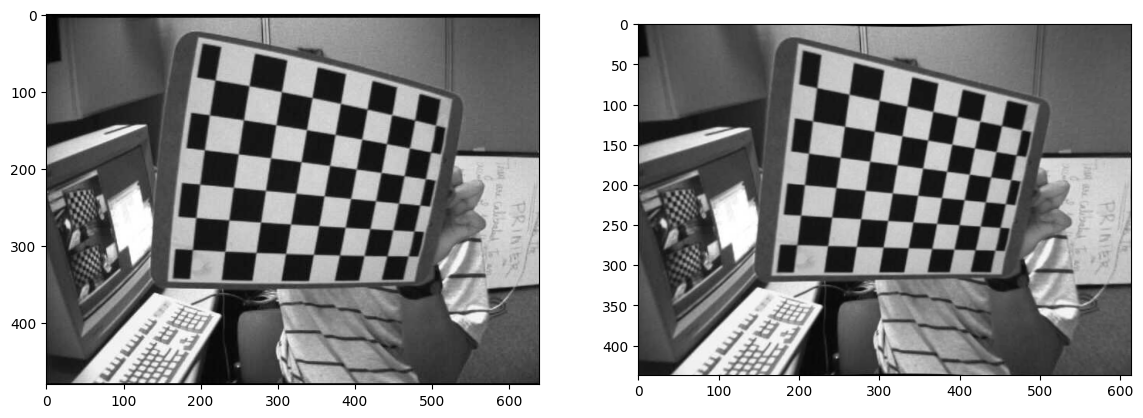

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14,12))
axes[0].imshow(img, 'gray')
axes[1].imshow(dst, 'gray')